# Section 5: Computations and Applications / Final Project

Coming to the end of the term we are going to combine and review topics from the last sections to answer computational questions involving matrices.

## Homework 5: Stationary methods for solving positive definite systems

In class you have discussed iterative methods for solving linear systems. In the following exercise we will implement a stationary method based on a few smoothers (L1 and variations of Gauss-Seidel).

In the code below I have implemented the algorithm for a smoother based stationary method. Stationary solvers are only garaunteed to converge for SPD systems, you might have justified this during lecture.

Your task in this exercise is to create the smoothers and evaluate the convergence rate for each. The smoothers to be implemented are:
*   L1
*   Forward Gauss-Seidel
*   Symmetric Gauss-Seidel

The `stationary` function I have implemented takes `smoother` as an argument. A cool feature of python is syntactically simple first class functions. All that means is functions can be treated just like any other variable. In this case, the `smoother` argument below is a function that takes some `residual` vector and returns the inverse action of the smoother on that vector. As an example, I have implemented Backward Gauss-Seidel.

In [ ]:
from numpy.linalg import norm
from scipy.io import mmread
from scipy.sparse import csr_matrix, tril, triu
from scipy.sparse.linalg import spsolve_triangular
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def stationary(A, rhs, guess, max_iter, epsilon, smoother):
  x = guess.copy()
  residual = rhs - A @ x
  r0_norm = norm(residual)
  norm_history = []

  for iter in range(max_iter):
    r_norm = norm(residual)
    norm_history.append(r_norm)

    if r_norm < epsilon * r0_norm:
      return (True, x, norm_history)
    
    x += smoother(residual)
    residual = rhs - A @ x
  
  return (False, x, norm_history)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Backward Gauss Seidel Solution

In [ ]:
folder = 'MyDrive/MTH343/matrices'
name = 'bcsstk05'
mat = mmread('/content/drive/MyDrive/MTH343/matrices/bcsstk05.mtx')
mat
upper = triu(mat, format='csr')
upper
print(mat)
print(upper)

  (0, 0)	314313.927913
  (3, 0)	-86857.8705282
  (4, 0)	56340.2403426
  (6, 0)	-35149.5467141
  (7, 0)	93732.1245708
  (8, 0)	-35149.5467141
  (9, 0)	-35149.5467141
  (10, 0)	-93732.1245708
  (11, 0)	35149.5467141
  (12, 0)	-86857.8705282
  (13, 0)	-56340.2403426
  (15, 0)	-35149.5467141
  (16, 0)	-93732.1245708
  (17, 0)	-35149.5467141
  (18, 0)	-35149.5467141
  (19, 0)	93732.1245708
  (20, 0)	35149.5467141
  (1, 1)	1072899.37028
  (2, 1)	4.65661287308e-10
  (3, 1)	56340.2403426
  (4, 1)	-36545.0207628
  (6, 1)	93732.1245708
  (7, 1)	-249952.332189
  (8, 1)	93732.1245708
  (9, 1)	-93732.1245708
  :	:
  (140, 141)	-4019.61386642
  (140, 142)	32843.1864695
  (140, 143)	-33970.6391393
  (140, 147)	-4019.61386642
  (140, 148)	-3886.2067684
  (140, 149)	-475.625305983
  (140, 150)	9329.71093047
  (140, 151)	-76230.5649197
  (140, 152)	-9329.71093047
  (141, 142)	-177397.555563
  (141, 143)	25079.7395703
  (141, 144)	-155446.236559
  (142, 143)	-206316.825007
  (143, 152)	-155446.236559
  (

In [ ]:
def bgs():
  #folder = 'MyDrive/MTH343/matrices'
  #name = 'bcsstk05'
  #mat = mmread(f'{folder}/{name}.mtx').tocsr()
  mat = mmread('/content/drive/MyDrive/MTH343/matrices/bcsstk05.mtx')
  upper = triu(mat, format='csr')

  def bgs_smoother(residual):
    return spsolve_triangular(upper, residual, lower=False)

  dim = mat.shape[0]
  return stationary(mat, np.ones(dim), np.zeros(dim), 2000, 1e-5, bgs_smoother)

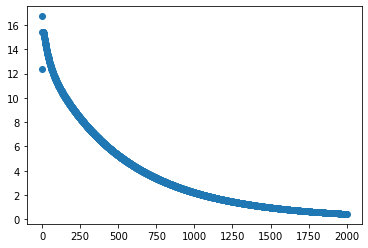

In [ ]:
#@title Default title text
converged, x, history = bgs()
x = np.arange(len(history))

plt.scatter(x, history)
plt.show()

In [ ]:
# Your code here

## Final Project

There are two algorithms for the final project. You will:
*   implement
*   test with various matrices
*   describe the results by plotting the convergence of the algorithm with respect to the iterations (may provide multiple plots for different sets of parameters)

The basic option is Arnoldi. A bonus part is implementing the Generalized Minimal Residual (GMRES) algorithm on top of it.

### Arnoldi Algorithm

Let $A$ be a given $n \times n$ matrix. We will use it only via its actions on any given vector $\mathbf p$, i.e., it may be given as a function with input $A$ and vector $\mathbf v$ which returns a vector $\mathbf w = A \mathbf v$.


The implementation requires computing inner products of vectors $\mathbf p$ and $\mathbf q$, and norm $\|.\|$ of vectors.
The output of the algorithm is a set of orthogonal vectors $\{\mathbf q_i\}$ and a $m \times m$ matrix $H = (h_{ij})$ where $h_{ij} = 0 $ for $i > j+1$.


- Input: matrix $A$, a vector $\mathbf r$, and an integer $m$. Typical values $m=5, 10, 50, ...$ (much smaller than the size $n$ of the matrix $A$).
- Output: matrix $Q=[\mathbf q_0,\mathbf q_1,\mathbf q_2, \cdots, \mathbf q_m]$ with orthonormal columns and an $m+1 \times m+1$ matrix $H = (h_{ij})$ with zeros below the 1st diagonal below  the main one.
If $A$ is symmetric, $H = (h_{ij})$ is also symmetric and hence becomes tridiagonal, that is, $h_{ij} = 0$ for $|i-j| > 1$ (all entries outside the band of the three main diagonals of the matrix are zero).

#### Algorithm

- Initialize $\mathbf q_0= \mathbf r/\|\mathbf r\|$.
-  Loop: For $j$ in range $(0,m)$:
  - $\mathbf v = A \mathbf q_j$.

  - Loop: For $i$ in range $(0,j+1)$:
    - $h_{ij} = \mathbf q^T_i \mathbf v$
    - $\mathbf v= \mathbf v-h_{ij}\mathbf q_i$
  - $h_{j+1,j} = \|\mathbf v\|$
  - $\mathbf q_{j+1} = \mathbf v/h_{j+1,j}$

#### Analysis
Use `scipy.linalg.eigh_tridiagonal` to get the eigenvalues of the resulting $H$ and plot the maximum and minimum eigenvalues as $H$ grows in size. Calculate the maximum and minimum eigenvalues of the matrix and plot these as horizonal lines on this results.

In [26]:
H = np.zeros((5+1, 5))
print(H.shape)
mat.shape[0]


(6, 5)


153

In [19]:
import numpy as np
from scipy import sparse
from scipy.io import mmread
from google.colab import drive
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from scipy.linalg import eigh
import tensorflow as tf
from IPython.display import HTML
from matplotlib import animation
drive.mount('/content/drive')
folder = 'MyDrive/MTH343/matrices'
name = 'bcsstk05'
mat = mmread('/content/drive/MyDrive/MTH343/matrices/bcsstk05.mtx')
"""
    Arnoldi algorithm (Krylov approximation of a matrix)
        input: 
            A: matrix to approximate
            v0: initial vector (should be in matrix form) 
            m: number of Krylov steps 
        output: 
            Q: matrix (large, N*k) containing the orthogonal vectors
            H: matrix (small, k*k) containing the Krylov approximation of A

"""
def Arnoldi_Algorithm(A, v0, m):
  H = np.zeros((m, m))
  Q = np.zeros((A.shape[0], m))
  # Normalize the input vector
  Q[:,0] = v0 / np.linalg.norm(v0)
  for i in range(m):
    v = A.dot(Q[:, i])
    for j in range(0, i+1):
      H[j, i] = np.dot(Q[:, j].T, v)
      v = v - np.dot(H[j, i], Q[:, j])
    if(i+1 < m):
      H[i+1, i] = np.linalg.norm(v)
      Q[:, i+1] = v / H[i+1, i]
  return H,Q

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


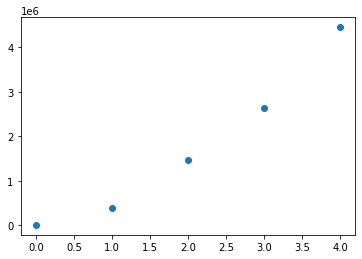

H is:
[[ 2.10098768e+04  1.16344383e+05 -4.72937245e-11  1.65300662e-10
  -1.20962795e-10]
 [ 1.16344383e+05  1.45571430e+06  7.16898734e+05  7.98536348e-10
  -1.32604328e-09]
 [ 0.00000000e+00  7.16898734e+05  1.93461798e+06  1.28317860e+06
  -1.76987669e-09]
 [ 0.00000000e+00  0.00000000e+00  1.28317860e+06  2.61981399e+06
   1.31462531e+06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.31462531e+06
   2.92254262e+06]]
Q is
[[ 8.08452083e-02 -1.45993113e-02  1.65247054e-02 -1.67574213e-02
   1.72651314e-02]
 [ 8.08452083e-02 -1.45993113e-02  1.65247053e-02 -1.67574213e-02
   1.72651314e-02]
 [ 8.08452083e-02 -1.45993113e-02  1.65247054e-02 -1.67574213e-02
   1.72651314e-02]
 [ 8.08452083e-02 -1.45993113e-02  1.65247054e-02 -1.67574213e-02
   1.72651314e-02]
 [ 8.08452083e-02 -1.45993113e-02  1.65247054e-02 -1.67574213e-02
   1.72651314e-02]
 [ 8.08452083e-02 -1.45993113e-02  1.65247054e-02 -1.67574213e-02
   1.72651314e-02]
 [ 8.08452083e-02 -1.45993113e-02  1.65247054e-02 -1.

In [20]:
#print(mat.shape)
# Random vector
V = np.ones(153)
#print(V.shape)
m1 = 5
h1, q1 = Arnoldi_Algorithm(mat, V, m1)
eigs = eigh_tridiagonal(np.diag(h1), np.diag(h1,k=-1), eigvals_only=True)
x = np.arange(len(eigs))
plt.scatter(x, eigs)
plt.show()

print("H is:")
print(h1)
print("Q is")
print(q1)

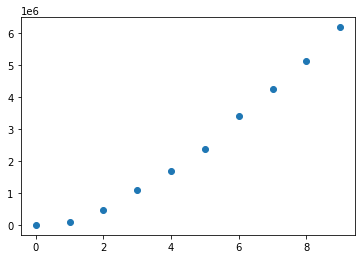

H is:
[[ 2.10098768e+04  1.16344383e+05 -4.72937245e-11  1.65300662e-10
  -1.20962795e-10  1.36424205e-11 -1.18234311e-10  2.06455297e-10
  -8.18545232e-11  9.64064384e-11]
 [ 1.16344383e+05  1.45571430e+06  7.16898734e+05  7.98536348e-10
  -1.32604328e-09  1.78806658e-09 -2.24963514e-09  2.60661182e-09
  -2.97768565e-09  3.29237082e-09]
 [ 0.00000000e+00  7.16898734e+05  1.93461798e+06  1.28317860e+06
  -1.76987669e-09  2.41016096e-09 -3.15776560e-09  3.69050213e-09
  -4.19913704e-09  4.70299710e-09]
 [ 0.00000000e+00  0.00000000e+00  1.28317860e+06  2.61981399e+06
   1.31462531e+06  1.52203938e-09 -1.97451300e-09  2.31102604e-09
  -2.64344635e-09  2.92129698e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.31462531e+06
   2.92254262e+06  1.57661223e+06 -1.98315320e-09  2.85399437e-09
  -3.75166564e-09  4.68753569e-09]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.57661223e+06  3.24651594e+06  1.62514649e+06  6.69751898e-09
  -1.00299076e-08  1.329317

In [21]:
m2 = 10
h2, q2 = Arnoldi_Algorithm(mat, V, m2)
eigs = eigh_tridiagonal(np.diag(h2), np.diag(h2,k=-1), eigvals_only=True)
x = np.arange(len(eigs))
plt.scatter(x, eigs)
plt.show()

print("H is:")
print(h2)
print("Q is")
print(q2)

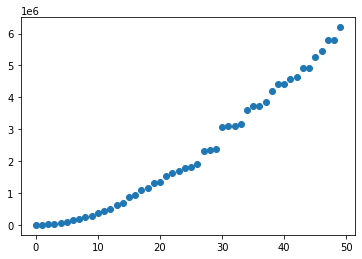

H is:
[[ 2.10098768e+04  1.16344383e+05 -4.72937245e-11 ...  1.76078174e-09
  -2.31375452e-09  2.55386112e-09]
 [ 1.16344383e+05  1.45571430e+06  7.16898734e+05 ...  4.15311661e-08
  -5.50317054e-08  5.88770490e-08]
 [ 0.00000000e+00  7.16898734e+05  1.93461798e+06 ...  3.97412805e-08
  -5.35437721e-08  5.81685526e-08]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.87506092e+06
   1.00931299e+06  4.36557457e-11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.00931299e+06
   1.74133620e+06  9.14124564e+05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   9.14124564e+05  1.25533750e+06]]
Q is
[[ 0.08084521 -0.01459931  0.01652471 ... -0.0063267  -0.0315809
   0.01462079]
 [ 0.08084521 -0.01459931  0.01652471 ... -0.04617225 -0.00238881
   0.09420752]
 [ 0.08084521 -0.01459931  0.01652471 ...  0.01105528 -0.03622259
   0.05384726]
 ...
 [ 0.08084521 -0.02768414 -0.09725543 ...  0.02626918  0.02288452
  -0.06136941]
 [ 0.08084521  0.4854506 

In [22]:
m3 = 50
h3, q3 = Arnoldi_Algorithm(mat, V, m3)
eigs = eigh_tridiagonal(np.diag(h3), np.diag(h3,k=-1), eigvals_only=True)
x = np.arange(len(eigs))
plt.scatter(x, eigs)
plt.show()

print("H is:")
print(h3)
print("Q is")
print(q3)

### Bonus: GMRES

Let $A$ be a given $n \times n$ matrix. 
The input for GMRES:

- matrix $A$
- r.h.s. $\mathbf b$
- initial iterate $\mathbf x_0$ (typical values: either zero, or random)
- *max_iter*, the maximal number of iterations allowed (typical values are 100, 1000)
- tolerance $\epsilon$ (typical; values are $10^{-6}$, $10^{-9}$)

The output of the algorithm is $\mathbf x$ the approximate solution, $iter$ - number of iterations used, $\|\mathbf r_0\|, \|\mathbf r\|$ - norm of the initial and  final residuals, and perhaps CPU time.



- Input: GMRES$(A, \mathbf b, \mathbf x_0, m, \mathbf x_0, \epsilon, \text{max_iter})$.

- Output $\mathbf x, \|\mathbf r\|, \|\mathbf r_0\|, \text{iter}, \text{time}$.

#### Algorithm

- Initiate:
  - $\mathbf r_0 = \mathbf b - A \mathbf x_0$, $\delta_0 = \|\mathbf r_0\|$.
  - $\mathbf r = \mathbf r_0$, $\mathbf x=\mathbf x_0$.

  - Loop: For $iter$ from $0$ to max_iter:
    - $P, H = \text{Arnoldi}(A, \mathbf r, m)$
    - $B = AP$.
    - $Q, R= \text{QR}(B)$.
    - $\mathbf z = Q^T\mathbf r$
    - $\mathbf \alpha = \text{upper\_triangual\_solve}(R, \mathbf z)$
    - $\mathbf x+=P\mathbf \alpha$
    - $\mathbf r -= B \mathbf \alpha$.
    - $\delta= \|\mathbf r\|$
    - If $\delta < \epsilon \delta_0$:
      - return $\mathbf x, \|\mathbf r\|, \|\mathbf r_0\|, \text{iter}$ (and CPU time).

#### Analysis
Run on all of the sparse matrices `*.mtx` from the data folder and plot iteration (or run-time) on x-axis and relative residual norm on y-axis.

#### Report

Make a few comments about each plot you generated. For Arnoldi, note which eigenvalues get better convergence and how well the algorithm works on different matrices (try with sparse/dense/large/small/etc).

Describe the algorithm and what each step is doing.